In [1]:
import numpy as np
import functions as fc
import fourier_continuation as fc_c
from timeit import default_timer as time
from fatiando.gravmag import polyprism, sphere
from fatiando import mesher, gridder,utils
from fatiando.constants import G, SI2MGAL
from scipy.sparse import diags
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from scipy import interpolate
from fatiando.vis import mpl
%matplotlib inline

C:\ProgramData\Anaconda2\lib\site-packages\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## Create the model

In [2]:
# Polygonal Prism model
verts1 = [[-500, -3000], [0, -3500], [4500, 0], [4000, 500]]
verts2 = [[4000, -3000], [4500, -2500], [0, 3500], [-500, 3000]]

model_prism = [mesher.PolygonalPrism(verts1, 900., 1500., props={'density':350}),
               mesher.PolygonalPrism(verts2, 1600., 2200., props={'density':400})]
R = 1000 #Radius
xc, yc, zc = -3000.,0.,2000. #Center of sphere
model_sphere = [mesher.Sphere(xc, yc, zc,R, props={'density':-500})]

## Grid and Forward model

In [3]:
# Create a regular grid at 0m height
shape = (100, 100)
area = [-5000, 5000, -4000, 4000]
xi, yi, zi = gridder.regular(area, shape, z=-100.)
print (area[1]-area[0])/(shape[0]-1.)

# Vertical component of the gravitational atraction observed
dobs_prism = polyprism.gz(xi, yi, zi, model_prism)
dobs_sphere = sphere.gz(xi, yi, zi, model_sphere)
dobs_0 = dobs_sphere + dobs_prism
dobs = utils.contaminate(dobs_0, 0.005, seed=0, percent=True)

101.01010101


In [4]:
np.mean(dobs-dobs_0)

6.494804694057166e-19

In [5]:
np.std(dobs-dobs_0)

0.014860348035367937

## True data plot

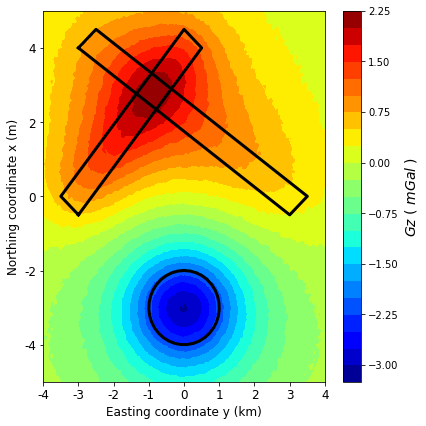

In [6]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc + R*np.cos(phi)
y = yc + R*np.sin(phi)

x_p = [-3000., -3500,0,500,-3000.]
y_p = [-500., 0,4500,4000,-500.]

x_p2 = [-3000, -2500,3500,3000,-3000.]
y_p2 = [4000, 4500,0,-500,4000]

# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.plot()
plt.tricontourf(yi,xi,dobs,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout(True)
#plt.savefig('figures/synthetic_data.png', dpi=300)

## Equivalent Layer Depth

In [7]:
# Equivalent Layer depth
zj = np.ones_like(zi)*300

## Fast Eq. Layer

In [8]:
# Predicted data
itmax = 40
s = time()
rho, gzp = fc.fast_eq(xi,yi,zi,zj,shape,dobs,itmax)
e = time()
tcpu = e - s
print tcpu, 'seconds'

8.2519045 seconds


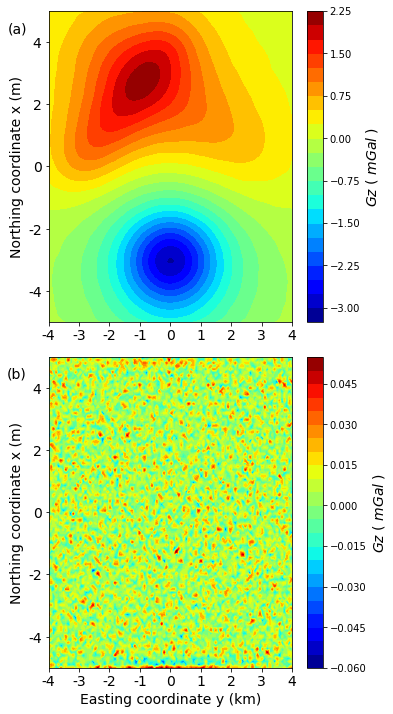

In [9]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(5.5,10))

#plt.subplot(311)
#plt.title('A)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,dobs,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
##plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()

plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,gzp,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz = gzp-dobs
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/classic_fast_val.png', dpi=300)

In [10]:
mean = np.mean(delta_gz)
print mean
std = np.std(delta_gz)
print std

-8.263613002363612e-07
0.014435138785293546


## Fast Eq. Layer BCCB

In [11]:
# Predicted data
itmax = 40
s = time()
rho_c, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,dobs,itmax)
e = time()
tcpu = e - s
print tcpu, 'seconds'

0.1085728 seconds


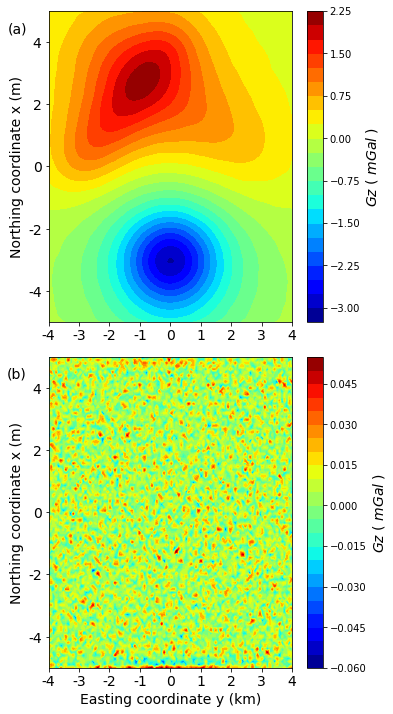

In [11]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(5.5,10))

#plt.subplot(311)
#plt.title('A)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,dobs,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
##plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()

plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,gzp_bccb,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_bccb = gzp_bccb-dobs
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_bccb,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/bccb_fast_val.png', dpi=300)

In [28]:
mean = np.mean(delta_gz)
print mean
std = np.std(delta_gz)
print std

NameError: name 'delta_gz' is not defined

## Mass distribution plot

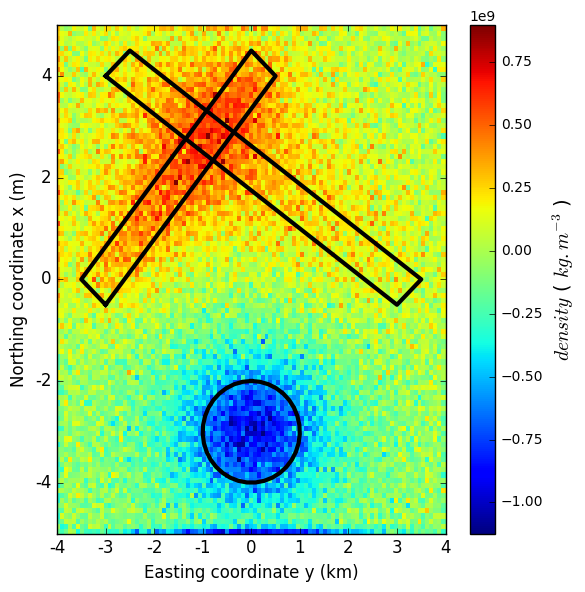

In [19]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc + R*np.cos(phi)
y = yc + R*np.sin(phi)

x_p = [-3000., -3500,0,500,-3000.]
y_p = [-500., 0,4500,4000,-500.]

x_p2 = [-3000, -2500,3500,3000,-3000.]
y_p2 = [4000, 4500,0,-500,4000]

plt.figure(figsize=(6,6))

plt.plot()
plt.pcolormesh(yi.reshape(shape), xi.reshape(shape),
               rho_c.reshape(shape))
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$density$ ( $kg.m^{-3}$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout(True)
#plt.savefig('figures/mass_distribution_bccb.png', dpi=300)
plt.show()

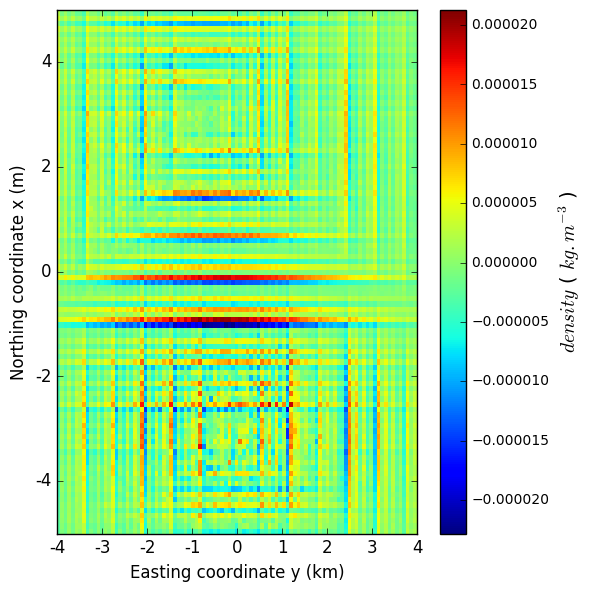

In [20]:
plt.figure(figsize=(6,6))
delta_rho = rho-rho_c
plt.plot()
plt.pcolormesh(yi.reshape(shape), xi.reshape(shape),
               delta_rho.reshape(shape))
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$density$ ( $kg.m^{-3}$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/delta_rho.png', dpi=300)
plt.show()

## Comparison Fast Vs BCCB

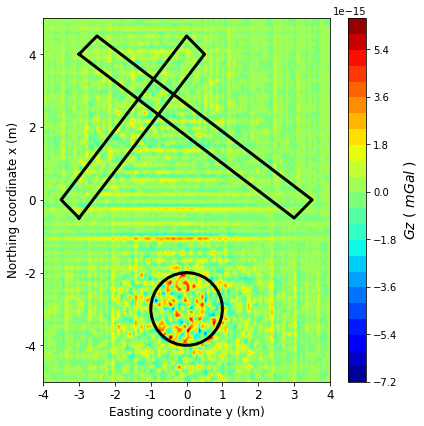

In [20]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))
delta_gzp = gzp-gzp_bccb
plt.plot()
plt.tricontourf(yi,xi,delta_gzp,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/delta_comparison.png', dpi=300)
#plt.plot(yi, xi, 'ko-', alpha=0.1)

In [21]:
mean = np.mean(delta_gzp)
print mean
std = np.std(delta_gzp)
print std

-1.4416641708550613e-17
8.7172169908975e-16


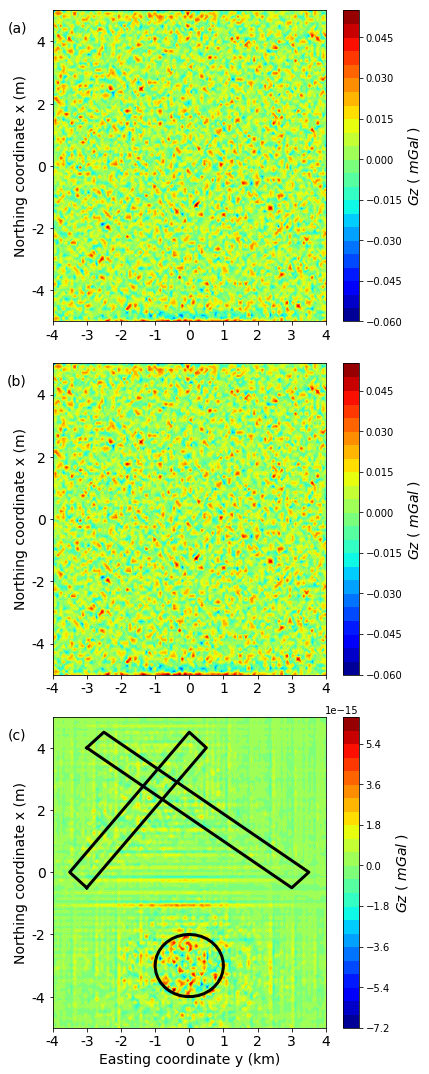

In [31]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,15))

plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_bccb,22,cmap='jet')
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gzp,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('../manuscript/Fig/Figure678_r1.png', dpi=300)

## Upward Continuation and Downward Continuation

In [32]:
N = shape[0]*shape[1]

# Real up e down data
xi, yi, zi_up = gridder.regular(area, shape, z=-300.)
xi, yi, zi_down = gridder.regular(area, shape, z=-50.)
# Vertical component of the gravitational atraction observed upward
dobs_prism_up = polyprism.gz(xi, yi, zi_up, model_prism)
dobs_sphere_up = sphere.gz(xi, yi, zi_up, model_sphere)
dobs_up = dobs_sphere_up + dobs_prism_up
#Vertical component of the gravitational atraction observed downward
dobs_prism_down = polyprism.gz(xi, yi, zi_down, model_prism)
dobs_sphere_down = sphere.gz(xi, yi, zi_down, model_sphere)
dobs_down = dobs_sphere_down + dobs_prism_down

#up BCCB
s = time()
#zi_up = np.ones_like(zi)*-300
BTTB_up = fc.bttb(xi,yi,zi_up,zj)
cev_up = fc.bccb(shape,N,BTTB_up)
gzp_bccb_up = fc.fast_forward_bccb(shape,N,rho_c,cev_up)
e = time()
tcpu = e - s
print tcpu, 'seconds'

s = time()
A = fc.sensibility_matrix(xi,yi,zi_up,zj,N)
gzp_up = A.dot(rho)
e = time()
tcpu = e - s
print tcpu, 'seconds'


#down BCCB
s = time()
#zi_down = np.ones_like(zi)*-50
BTTB_down = fc.bttb(xi,yi,zi_down,zj)
cev_down = fc.bccb(shape,N,BTTB_down)
gzp_bccb_down = fc.fast_forward_bccb(shape,N,rho_c,cev_down)
e = time()
tcpu = e - s
print tcpu, 'seconds'

s = time()
A = fc.sensibility_matrix(xi,yi,zi_down,zj,N)
gzp_down = A.dot(rho)
e = time()
tcpu = e - s
print tcpu, 'seconds'

0.00559610000073 seconds
6.942355 seconds
0.00783619999947 seconds
7.5196863 seconds


### Upward plot

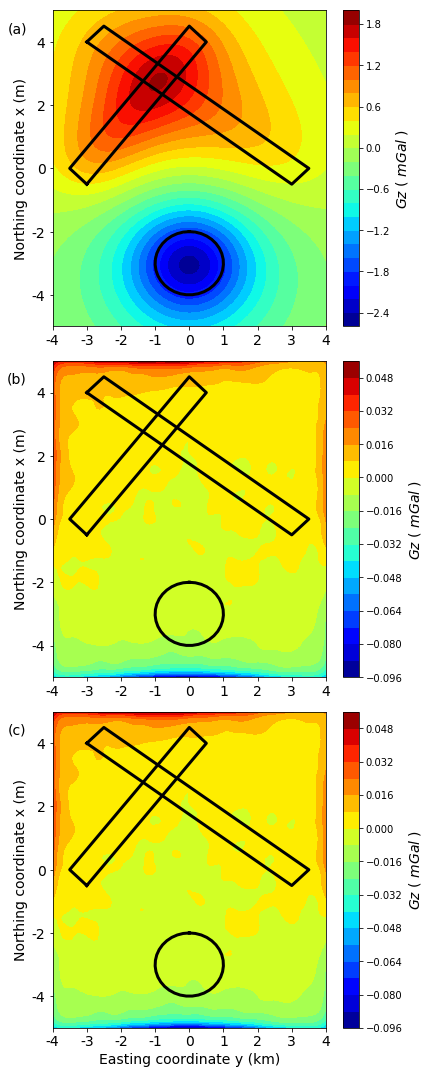

In [14]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6.0,15))

plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,dobs_up,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_up = dobs_up-gzp_up
plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_up,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_bccb_up = dobs_up-gzp_bccb_up
plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_bccb_up,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('../manuscript/Fig/Figure10_r1.png', dpi=300)

In [16]:
mean = np.mean(delta_gz_up)
print mean
std = np.std(delta_gz_up)
print std
mean = np.mean(delta_gz_bccb_up)
print mean
std = np.std(delta_gz_bccb_up)
print std

-0.00030469714026037844
0.012406700653062496
-0.00030469714026038657
0.012406700653062385


In [43]:
# plot of the vertical component of the gravitational atraction at z=0 
#plt.figure(figsize=(5.5,15))
#
#plt.subplot(311)
#plt.title('A)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,gzp_up,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
##plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()
#
#plt.subplot(312)
#plt.title('B)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,gzp_bccb_up,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
##plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()
#
#delta_gz_up = gzp_bccb_up-gzp_up
#plt.subplot(313)
#plt.title('C)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,delta_gz_up,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()
#plt.tight_layout(True)
#plt.savefig('figures/upward_comparison.png', dpi=300)

In [18]:
mean = np.mean(delta_gz_up)
print mean
std = np.std(delta_gz_up)
print std

-5.93786630108e-18
8.70144258307e-16


### Downward plot

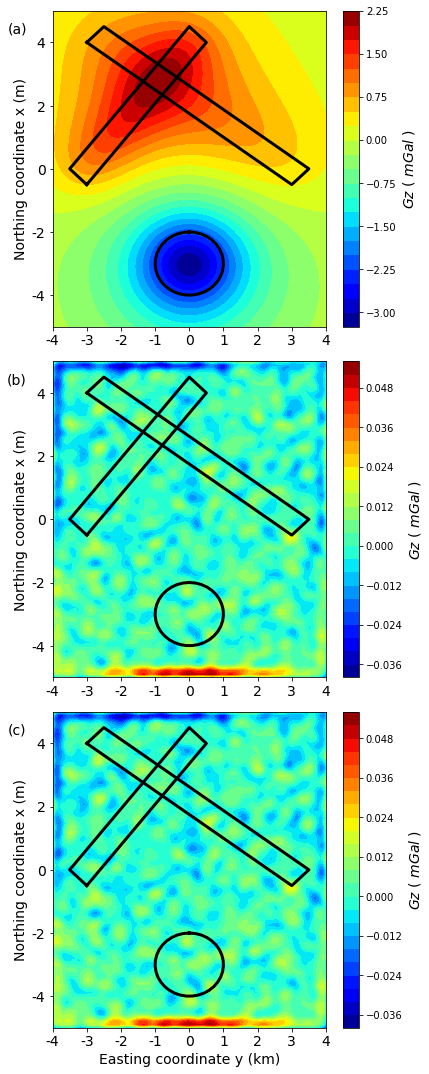

In [35]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6.0,15))

plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,dobs_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_down = dobs_down-gzp_down
plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

delta_gz_bccb_down = dobs_down-gzp_bccb_down
plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,delta_gz_bccb_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('../manuscript/Fig/Figure11_r1.png', dpi=300)

In [34]:
mean = np.mean(delta_gz_down)
print mean
std = np.std(delta_gz_down)
print std
mean = np.mean(delta_gz_bccb_down)
print mean
std = np.std(delta_gz_bccb_down)
print std

8.209236592166969e-05
0.007910431382710465
8.209236592165734e-05
0.007910431382710477


In [42]:
## plot of the vertical component of the gravitational atraction at z=0 
#plt.figure(figsize=(5.5,15))
#
#plt.subplot(311)
#plt.title('A)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,gzp_down,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
##plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()
#
#plt.subplot(312)
#plt.title('B)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,gzp_bccb_down,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
##plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()
#
#delta_gz_down = gzp_bccb_down-gzp_down
#plt.subplot(313)
#plt.title('C)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(yi,xi,delta_gz_down,22,cmap='jet')
#cb = plt.colorbar(shrink=1)
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi),np.max(yi))
#plt.ylim(np.min(xi),np.max(xi))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (m)', fontsize=14)
#mpl.m2km()
#plt.tight_layout(True)
#plt.savefig('figures/downward_comparison.png', dpi=300)

In [20]:
mean = np.mean(delta_gz_down)
print mean
std = np.std(delta_gz_down)
print std

5.91393253813e-18
9.0149472025e-16


## Comparison Upward - Fourier vs. BCCB

In [12]:
N = shape[0]*shape[1]

dobs_low = utils.contaminate(dobs_0, 0.005, seed=0, percent=True)
dobs_med = utils.contaminate(dobs_0, 0.02, seed=0, percent=True)
dobs_high = utils.contaminate(dobs_0, 0.1, seed=0, percent=True)

xi, yi, zi_up = gridder.regular(area, shape, z=-300.)

# True upward continuation of the gravitational atraction observed data
dobs_prism_up = polyprism.gz(xi, yi, zi_up, model_prism)
dobs_sphere_up = sphere.gz(xi, yi, zi_up, model_sphere)
dobs_up = dobs_sphere_up + dobs_prism_up

In [13]:
print np.std(dobs_low-dobs_0)
print np.std(dobs_med-dobs_0)
print np.std(dobs_high-dobs_0)

0.014860348035367937
0.05944139214147175
0.29720696070735875


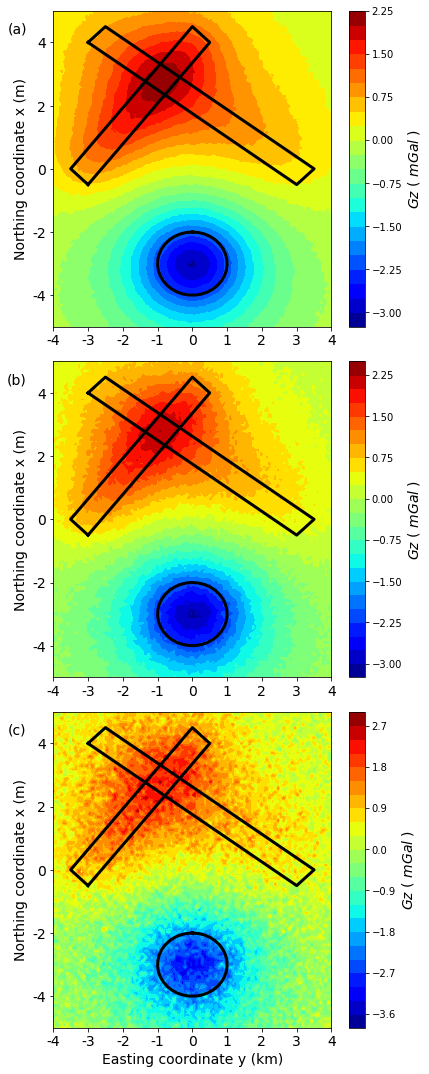

In [34]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6.0,15))

plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,dobs_low,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,dobs_med,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,dobs_high,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/Figure15_r1.png', dpi=300)

In [17]:
# Up Fourier
gzp_fourier_up_low = fc_c.upcontinue(xi, yi, dobs_low, shape, 200)
gzp_fourier_up_med = fc_c.upcontinue(xi, yi, dobs_med, shape, 200)
gzp_fourier_up_high = fc_c.upcontinue(xi, yi, dobs_high, shape, 200)

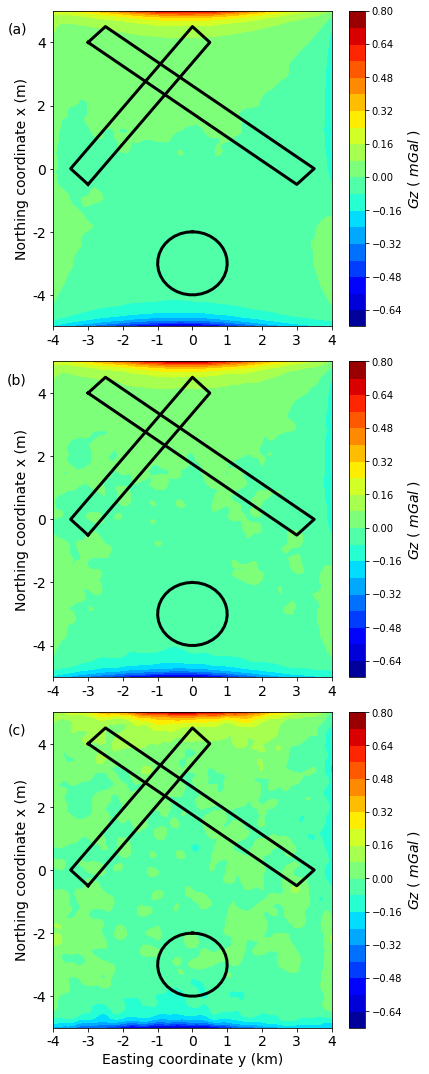

In [35]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6.0,15))

up_low = dobs_up-np.ravel(gzp_fourier_up_low)
plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,up_low,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

up_med = dobs_up-np.ravel(gzp_fourier_up_med)
plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,up_med,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

up_high = dobs_up-np.ravel(gzp_fourier_up_high)
plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,up_high,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/Figure16_r1.png', dpi=300)

In [36]:
print np.std(up_low)
print np.std(up_med)
print np.std(up_high)

0.09594941619524969
0.09612393612930935
0.10008593173982241


In [22]:
rho_low, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,dobs_low,itmax)
rho_med, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,dobs_med,itmax)
rho_high, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,dobs_high,itmax)

#Up BCCB
BTTB_up = fc.bttb(xi,yi,zi_up,zj)
cev_up = fc.bccb(shape,N,BTTB_up)
gzp_bccb_up_low = fc.fast_forward_bccb(shape,N,rho_low,cev_up)
gzp_bccb_up_med = fc.fast_forward_bccb(shape,N,rho_med,cev_up)
gzp_bccb_up_high = fc.fast_forward_bccb(shape,N,rho_high,cev_up)

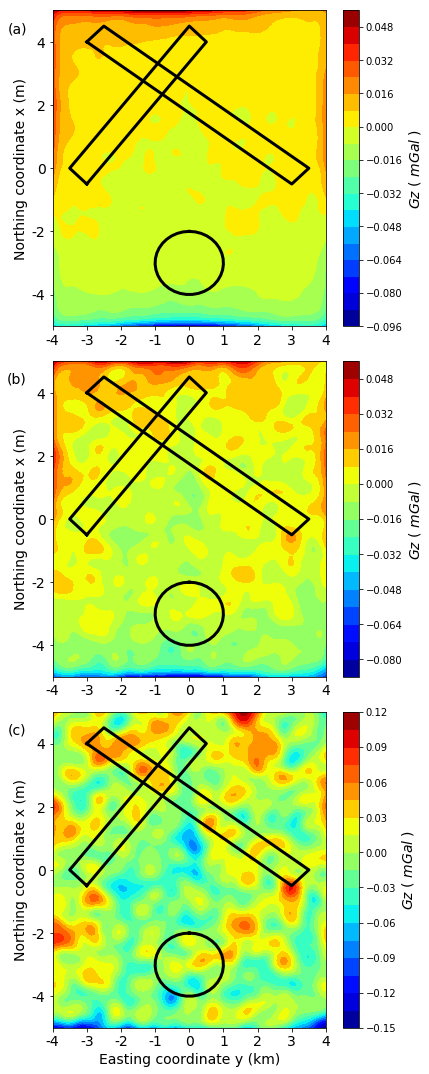

In [37]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6.0,15))

up_low2 = dobs_up-gzp_bccb_up_low
plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,up_low2,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

up_med2 = dobs_up-gzp_bccb_up_med
plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,up_med2,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

up_high2 = dobs_up-gzp_bccb_up_high
plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,up_high2,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/Figure17_r1.png', dpi=300)

In [25]:
print np.std(up_low2)
print np.std(up_med2)
print np.std(up_high2)

0.012406700653062385
0.013014994191686209
0.0282013180749982


## Comparison Downward - Fourier vs. BCCB

In [26]:
xi, yi, zi_down = gridder.regular(area, shape, z=-50.)
#Vertical component of the gravitational atraction observed downward
dobs_prism_down = polyprism.gz(xi, yi, zi_down, model_prism)
dobs_sphere_down = sphere.gz(xi, yi, zi_down, model_sphere)
dobs_down = dobs_sphere_down + dobs_prism_down

In [27]:
# Down Fourier
gzp_fourier_down_low = fc_c.upcontinue(xi, yi, dobs_low, shape, -50)
gzp_fourier_down_med = fc_c.upcontinue(xi, yi, dobs_med, shape, -50)
gzp_fourier_down_high = fc_c.upcontinue(xi, yi, dobs_high, shape, -50)

fourier_continuation.py:57: UserWarning: Using 'height' <= 0 means downward continuation, which is known to be unstable.
  "which is known to be unstable.")


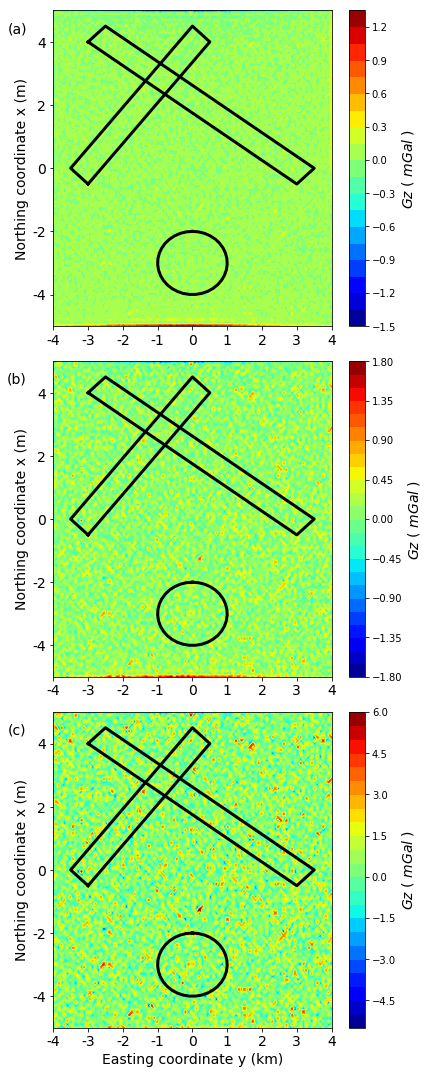

In [38]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6.0,15))

down_low = dobs_down-np.ravel(gzp_fourier_down_low)
plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,down_low,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

down_med = dobs_down-np.ravel(gzp_fourier_down_med)
plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,down_med,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

down_high = dobs_down-np.ravel(gzp_fourier_down_high)
plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,down_high,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/Figure18_r1.png', dpi=300)

In [39]:
print np.std(down_low)
print np.std(down_med)
print np.std(down_high)

0.1393794456865433
0.3133497148031218
1.4500303989569285


In [30]:
#Down BCCB
BTTB_down = fc.bttb(xi,yi,zi_down,zj)
cev_down = fc.bccb(shape,N,BTTB_down)
gzp_bccb_down_low = fc.fast_forward_bccb(shape,N,rho_low,cev_down)
gzp_bccb_down_med = fc.fast_forward_bccb(shape,N,rho_med,cev_down)
gzp_bccb_down_high = fc.fast_forward_bccb(shape,N,rho_high,cev_down)

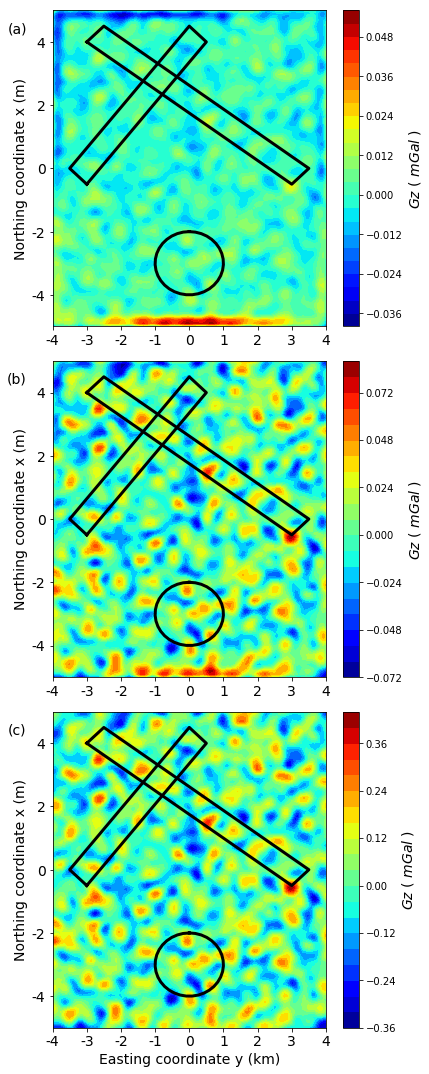

In [40]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6.0,15))

down_low2 = dobs_down-gzp_bccb_down_low
plt.subplot(311)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,down_low2,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

down_med2 = dobs_down-gzp_bccb_down_med
plt.subplot(312)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,down_med2,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

down_high2 = dobs_down-gzp_bccb_down_high
plt.subplot(313)
plt.title('(c)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi,xi,down_high2,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/Figure19_r1.png', dpi=300)

In [41]:
print np.std(down_low2)
print np.std(down_med2)
print np.std(down_high2)

0.007910431382710477
0.02163657108506452
0.10370521498174366
